In [25]:
import pandas as pd
import numpy as np
import os
import csv
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
import src.comercio
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN

warnings.filterwarnings("ignore")

In [2]:
archivos = os.listdir('data/')
df_t = pd.DataFrame()
for i in range(len(archivos)):
    df = src.comercio.lecture_data('data/' + archivos[i]) 
    df_t = pd.concat([df_t, df])

b'Skipping line 280230: expected 42 fields, saw 43\n'
b'Skipping line 188790: expected 42 fields, saw 43\n'


# Ejemplo localización solo Querétaro

In [3]:
level_col = ['tipo_vial','nombre_act']
encoder = LabelEncoder()
df_t2 = df_t.copy()
for col in level_col:
    df_t2[col+'_encode'] = encoder.fit_transform(df_t[col])

In [4]:
df_t2_queretaro = df_t2[(df_t2['entidad']=='Querétaro')&(df_t2['municipio']=='Querétaro')]

In [5]:
m = folium.Map(location=[19.344720000, -99.199660000], zoom_start=6)
for _,row in df_t2_queretaro.iterrows():
    folium.Circle(location=[float(row['latitud']),float(row['longitud'])],
                    radius=row['per_ocu']
                   ).add_to(m)

In [6]:
m

# Análisis datos

array([[<AxesSubplot:title={'center':'tipo_vial_encode'}>,
        <AxesSubplot:title={'center':'nombre_act_encode'}>],
       [<AxesSubplot:title={'center':'per_ocu'}>, <AxesSubplot:>]],
      dtype=object)

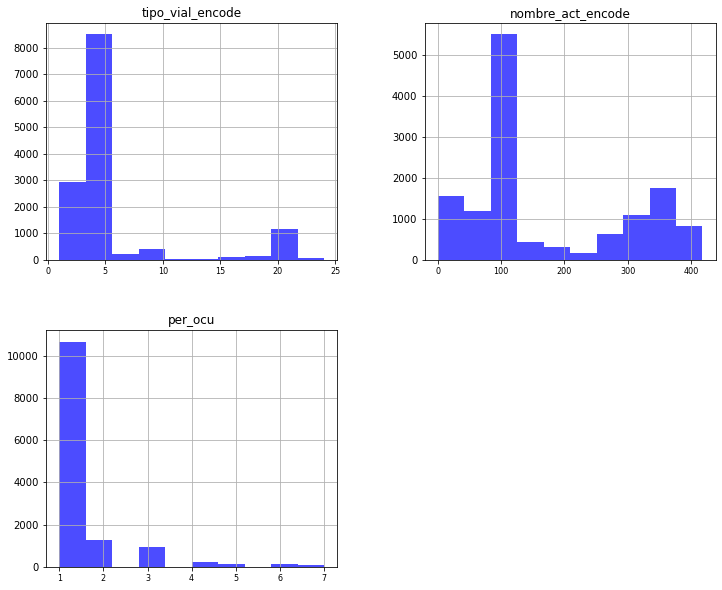

In [7]:
objetivo = ['tipo_vial_encode','nombre_act_encode','per_ocu']
df_t2_queretaro[objetivo].hist(xlabelsize=8, figsize =(12,10),color = 'blue', alpha=0.7)

Text(0.5, 1.0, 'Matrix Correlation')

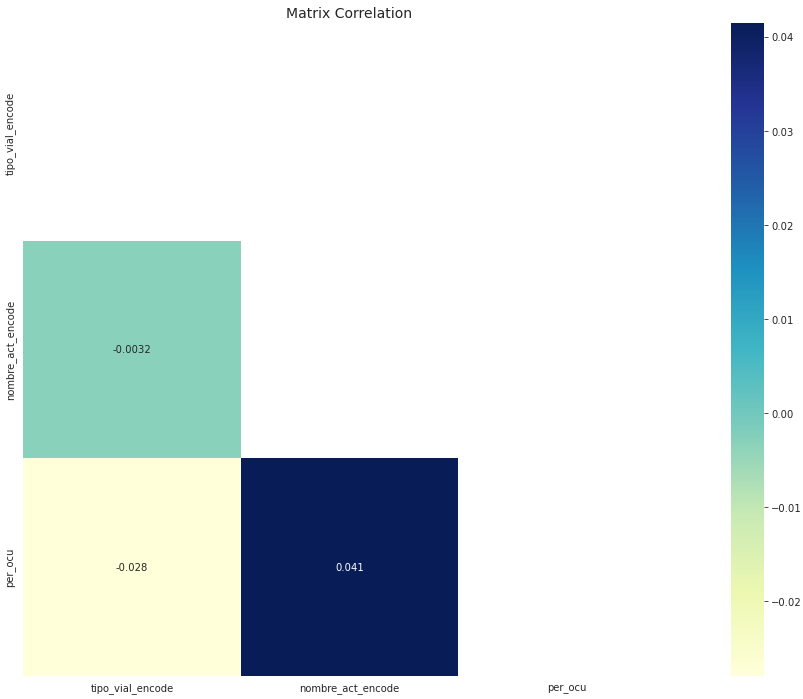

In [8]:
matriz = df_t2_queretaro[objetivo].corr(method='spearman')
plt.figure(figsize=(20, 12))
mask = np.zeros_like(matriz)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    sns.heatmap(matriz,yticklabels = list(matriz),xticklabels= list(matriz), cmap = 'YlGnBu',square = True,mask = mask,annot = True)
plt.title('Matrix Correlation',fontsize = 14)

# Modelo

In [86]:
df_t3_queretaro = df_t2_queretaro[objetivo].dropna()
df_t3_queretaro.count()

tipo_vial_encode     13440
nombre_act_encode    13440
per_ocu              13440
dtype: int64

In [87]:
dbsc =DBSCAN(eps = 0.001, min_samples = 5) #0.001 y 5 
dbsc.fit(df_t3_queretaro)

DBSCAN(eps=0.001)

In [88]:
dbsc.get_params

<bound method BaseEstimator.get_params of DBSCAN(eps=0.001)>

In [89]:
labels = dbsc.labels_
len(np.unique(labels))

446

In [90]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % src.comercio.silhouette_score(df_t3_queretaro, labels))

Estimated number of clusters: 445
Estimated number of noise points: 2785
Silhouette Coefficient: 0.590


In [95]:
base_etiquetada = df_t2_queretaro.join(pd.DataFrame({'etiqueta':labels},index = df_t3_queretaro.index))

In [97]:
# base_etiquetada.groupby('etiqueta').count()
base_etiquetada.head()

nom_estab  \
id                                                   
3546860                    VENTA DE CALZADO ANDREA   
3546861              TALLER DE SOLDADURA CERVANTES   
3546867                             SASTRERIA RICO   
3546873                       BORDADOS UNIVERSALES   
3546877  ASESORIA AGROPECUARIA Y FORESTAL INTEGRAL   

                                             raz_social  codigo_act  \
id                                                                    
3546860                                             NaN      463310   
3546861                                             NaN      332320   
3546867                                             NaN      315225   
3546873                                             NaN      314991   
3546877  ASESORIA AGROPECUARIA Y FORESTAL E INTEGRAL SC      541690   

                                                nombre_act  per_ocu tipo_vial  \
id                                                                              
3546860                   Comercio al por menor de calzado        1   AVENIDA   
3546861               Fabricación de productos de herrería        1   AVENIDA   
3546867       Confección de prendas de vestir sobre medida        1   AVENIDA   
3546873  Confección, bordado y deshilado de productos t...        1   AVENIDA   
3546877  Otros servicios de consultoría científica y té...        2   AVENIDA   

                     nom_vial tipo_v_e_1        nom_v_e_1 tipo_v_e_2  ...  \
id                                                                    ...   
3546860  EJERCITO REPUBLICANO      CALLE          NINGUNO    AVENIDA  ...   
3546861  EJERCITO REPUBLICANO      CALLE          NINGUNO    AVENIDA  ...   
3546867       20 DE NOVIEMBRE      CALLE    REVILLAGIGEDO      CALLE  ...   
3546873      IGNACIO ZARAGOZA    AVENIDA  20 DE NOVIEMBRE    AVENIDA  ...   
3546877      IGNACIO ZARAGOZA    AVENIDA  20 DE NOVIEMBRE    AVENIDA  ...   

                              correoelec  www tipoUniEco    latitud  \
id                                                                    
3546860                              NaN  NaN        NaN  20.591246   
3546861                              NaN  NaN        NaN  20.591052   
3546867                              NaN  NaN        NaN  20.591219   
3546873  BORDADOSUNIVERSALES@HOTMAIL.COM  NaN        NaN  20.591339   
3546877  AAFORESTALINTEGRAL@YAHOO.COM.MX  NaN        NaN  20.591372   

           longitud fecha_alta es_esencial  tipo_vial_encode  \
id                                                             
3546860 -100.377809    2010-07           0                 3   
3546861 -100.377407    2010-07           0                 3   
3546867 -100.378989    2010-07           0                 3   
3546873 -100.380833    2010-07           0                 3   
3546877 -100.380410    2010-07           0                 3   

        nombre_act_encode etiqueta  
id                                  
3546860               102        0  
3546861               271        1  
3546867               136        2  
3546873               143        3  
3546877               328       -1  

[5 rows x 44 columns]

In [94]:
identified_clusters = dbsc.fit_predict(df_t3_queretaro.head())
identified_clusters

array([-1, -1, -1, -1, -1], dtype=int64)